## Reference design - compare DA methods

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [50]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [51]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [52]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [100]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_DAmethods/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [101]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


### Run reference design comparison and parse results

See `submit_oor_design_v2.sh`

## Read outputs

In [81]:
def _read_oor_design(simdir, res_type = 'AUPRC', emb_method='scArches', diff_method = 'meld'):
    res_file = glob.glob(f'{simdir}/{res_type}_res.{emb_method}_{diff_method}.csv')
    assert len(res_file) == 1
    r = pd.read_csv(res_file[0], index_col=0)
    r['emb_method'] = emb_method
    r['diff_method'] = diff_method
    return(r)

In [82]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

In [83]:
AUPRC_df = pd.DataFrame()
for d in dirs:
    for m in ['meld', 'cna', 'milo']:
        try:
            r = _read_oor_design(outdir + d, diff_method=m)
            r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
        except AssertionError:
            continue
        AUPRC_df = pd.concat([AUPRC_df, r])

/tmp/ipykernel_8683/2816793471.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_8683/2816793471.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_8683/2816793471.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_8683/2816793471.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_8683/2816793471.py:6: FutureWarning: In a future version of pandas all ar

In [84]:
TPR_df = pd.DataFrame()
for d in dirs:
    for m in ['meld', 'cna', 'milo']:
        try:
            r = _read_oor_design(outdir + d, res_type="TPR", diff_method=m)
#             r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
        except AssertionError:
            continue
        TPR_df = pd.concat([TPR_df, r])

### Plot metrics

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


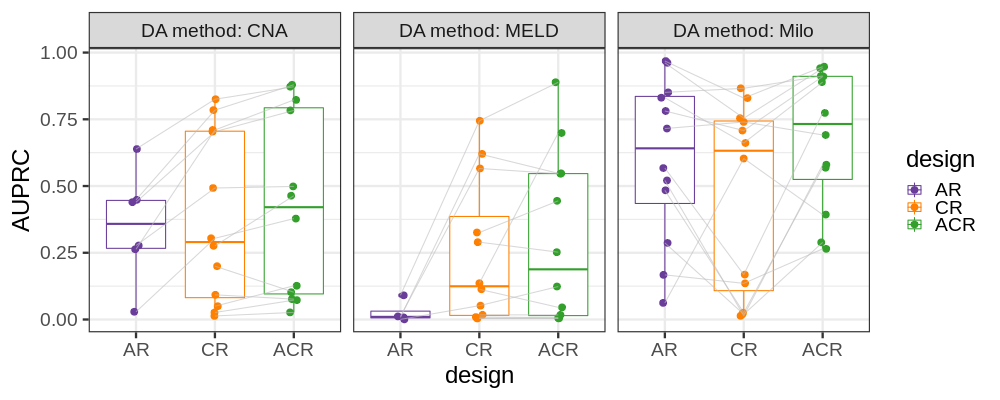

In [102]:
%%R -i AUPRC_df -w 1000 -h 400
AUPRC_df %>%
    filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
    mutate(`DA method` = ifelse(diff_method == 'milo', 'Milo', toupper(diff_method))) %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) %>%
    ggplot(aes(design, AUPRC, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    scale_color_brewer(palette='Accent', 
                       labels=c(logFC='DA logFC (ACR design)', 
                           mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                           mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
    theme_bw(base_size=24) +
    facet_grid(.~`DA method`, labeller='label_both') +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    ggsave(paste0(figdir, 'AUPRC_boxplot_design.png'), width=12, height=5) +
    ggsave(paste0(figdir, 'AUPRC_boxplot_design.pdf'), width=12, height=5)


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


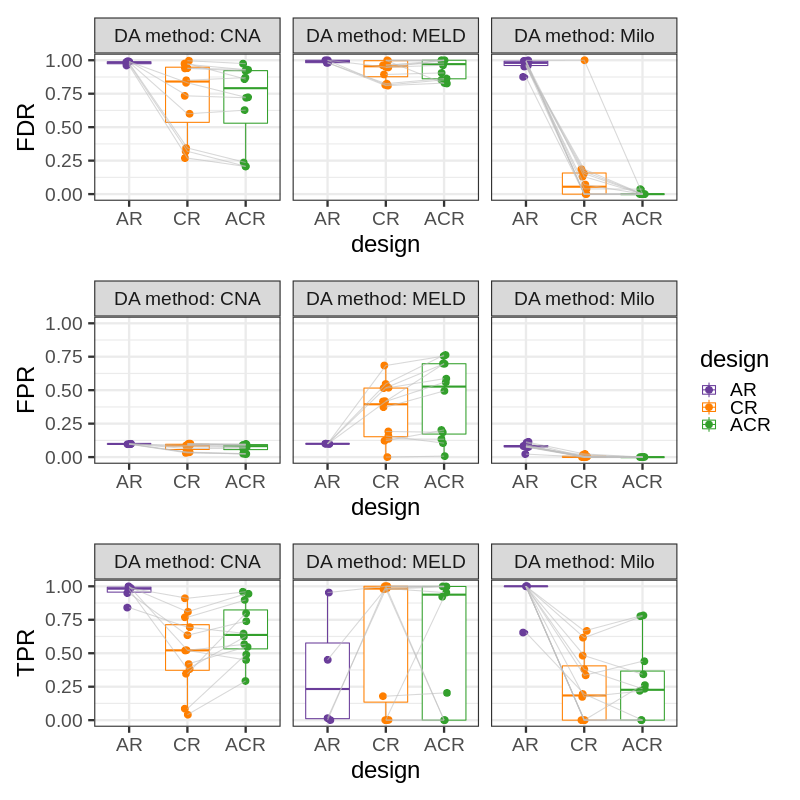

In [104]:
%%R -i TPR_df -w 800 -h 800
library(patchwork)

pl_df <- TPR_df %>%
    pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
    filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
    mutate(`DA method` = ifelse(diff_method == 'milo', 'Milo', toupper(diff_method))) %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) 

pl_ls <- lapply(c('FDR', "FPR", "TPR"), function(m) pl_df %>%
                filter(metric == m) %>%
                ggplot(aes(design, value, color=design)) +
                geom_boxplot() +
                geom_jitter(size=3, width=0.05) +
                geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
                scale_color_brewer(palette='Accent', 
                                   labels=c(logFC='DA logFC (ACR design)', 
                                       mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                                       mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
                theme_bw(base_size=24) +
                ylab(m) + ylim(0,1) +
                facet_grid(.~`DA method`, labeller='label_both') +
                scale_color_manual(values=design_palette) +
                theme_bw(base_size=24))

wrap_plots(pl_ls) + plot_layout(ncol=1, guides='collect') +
    ggsave(paste0(figdir, 'metrics_boxplot_design.png'), width=10, height=10) +
    ggsave(paste0(figdir, 'metrics_boxplot_design.pdf'), width=10, height=10)


---

### MELD

In [20]:
meld_nhood_df = pd.DataFrame()
for d in dirs:
    nhood_obs_df = pd.read_csv(outdir + d + '/nhoods_obs.scArches_meld.csv', index_col=0)
    meld_nhood_df = pd.concat([meld_nhood_df, nhood_obs_df])

In [21]:
%%R -i meld_nhood_df
head(meld_nhood_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


   sex tissue ethnicity disease                          assay
1 male  blood   unknown  normal 10x 3' transcription profiling
2 male  blood   unknown  normal 10x 3' transcription profiling
3 male  blood   unknown  normal 10x 3' transcription profiling
4 male  blood   unknown  normal 10x 3' transcription profiling
5 male  blood   unknown  normal 10x 3' transcription profiling
6 male  blood   unknown  normal 10x 3' transcription profiling
  assay_ontology_term_id sample_id  donor_id                 dataset_id
1            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
2            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
3            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
4            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
5            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
6            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
          development_stage                       cell_

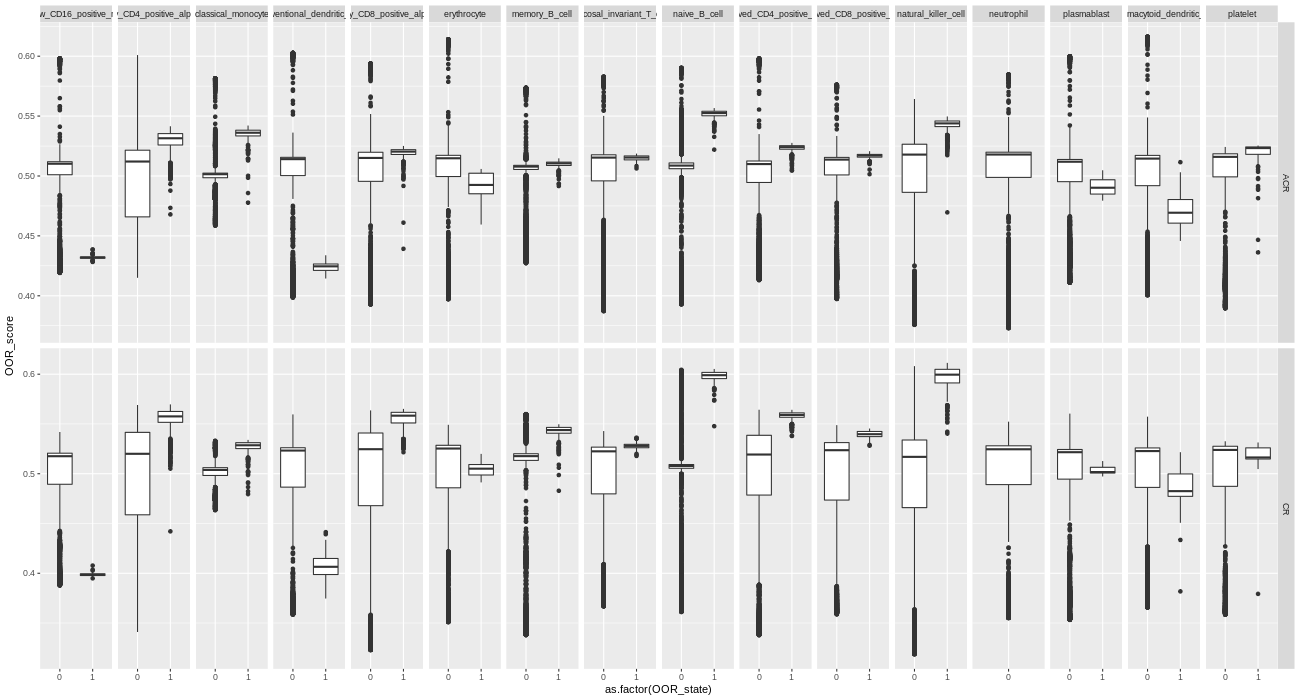

In [22]:
%%R -w 1300 -h 700
meld_nhood_df %>%
ggplot(aes(as.factor(OOR_state), OOR_score)) +
geom_boxplot() +
# geom_jitter() +
facet_grid(design~OOR_state_name, scales='free')

Fix direction:

In [23]:
mean_score = meld_nhood_df.groupby(['OOR_state_name', 'OOR_state'])['OOR_score'].median().reset_index()
mean_score = mean_score.pivot(index='OOR_state_name', columns='OOR_state', values='OOR_score')
switch_prob = mean_score[1] < mean_score[0]
switch_prob = mean_score.index[switch_prob]
meld_nhood_df['OOR_score'] = np.where(meld_nhood_df['OOR_state_name'].isin(switch_prob), 1 - meld_nhood_df['OOR_score'], meld_nhood_df['OOR_score'])

In [24]:
%%R -i meld_nhood_df
head(meld_nhood_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


   sex tissue ethnicity disease                          assay
1 male  blood   unknown  normal 10x 3' transcription profiling
2 male  blood   unknown  normal 10x 3' transcription profiling
3 male  blood   unknown  normal 10x 3' transcription profiling
4 male  blood   unknown  normal 10x 3' transcription profiling
5 male  blood   unknown  normal 10x 3' transcription profiling
6 male  blood   unknown  normal 10x 3' transcription profiling
  assay_ontology_term_id sample_id  donor_id                 dataset_id
1            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
2            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
3            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
4            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
5            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
6            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
          development_stage                       cell_

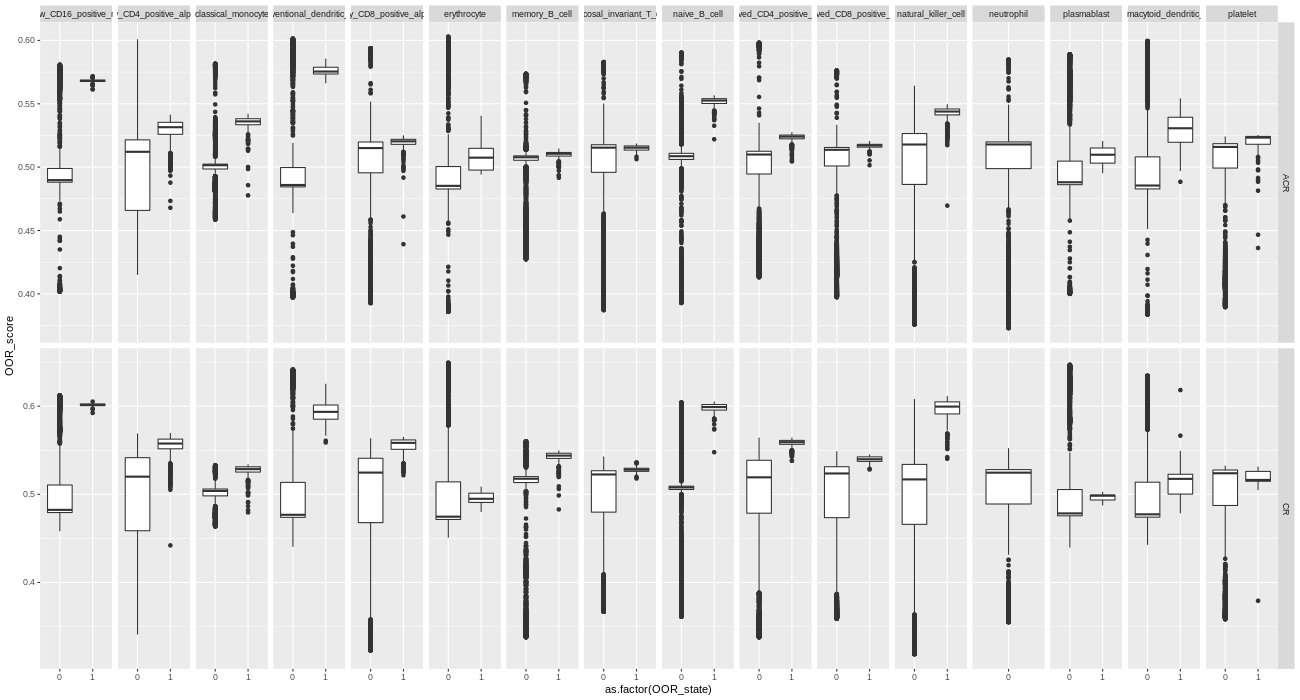

In [25]:
%%R -w 1300 -h 700
meld_nhood_df %>%
ggplot(aes(as.factor(OOR_state), OOR_score)) +
geom_boxplot() +
# geom_jitter() +
facet_grid(design~OOR_state_name, scales='free')

In [26]:
meld_auprc_df = pd.DataFrame()
for ct in meld_nhood_df['OOR_state_name'].unique():
    for d in meld_nhood_df['design'].unique():
        auprc_df = auprc.auprc(meld_nhood_df[(meld_nhood_df['OOR_state_name'] == ct) & (meld_nhood_df['design'] == d)], return_curve=True)
        auprc_df['design'] = d
        auprc_df['OOR_state_name'] = ct
        meld_auprc_df = pd.concat([meld_auprc_df, auprc_df])

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [27]:
%%R -i meld_auprc_df
head(meld_auprc_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision      AUPRC no_skill_thresh design OOR_state_name
1      1 0.02883640 0.08058341       0.0288364    ACR  memory_B_cell
2      1 0.02883849 0.08058341       0.0288364    ACR  memory_B_cell
3      1 0.02884058 0.08058341       0.0288364    ACR  memory_B_cell
4      1 0.02884267 0.08058341       0.0288364    ACR  memory_B_cell
5      1 0.02884476 0.08058341       0.0288364    ACR  memory_B_cell
6      1 0.02884685 0.08058341       0.0288364    ACR  memory_B_cell


`summarise()` has grouped output by 'OOR_state_name'. You can override using
the `.groups` argument.


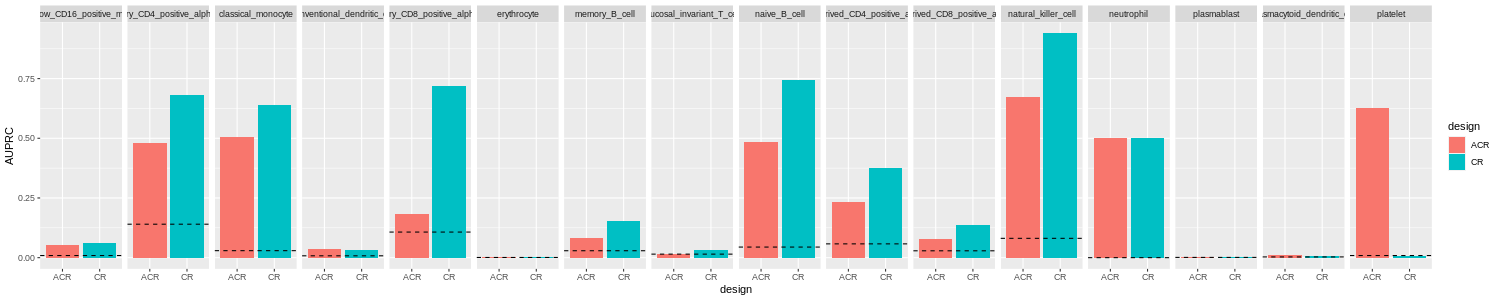

In [28]:
%%R -w 1500 -h 300
meld_auprc_df %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(OOR_state_name, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(OOR_state_name~., nrow=1)

`summarise()` has grouped output by 'OOR_state_name'. You can override using the `.groups` argument.


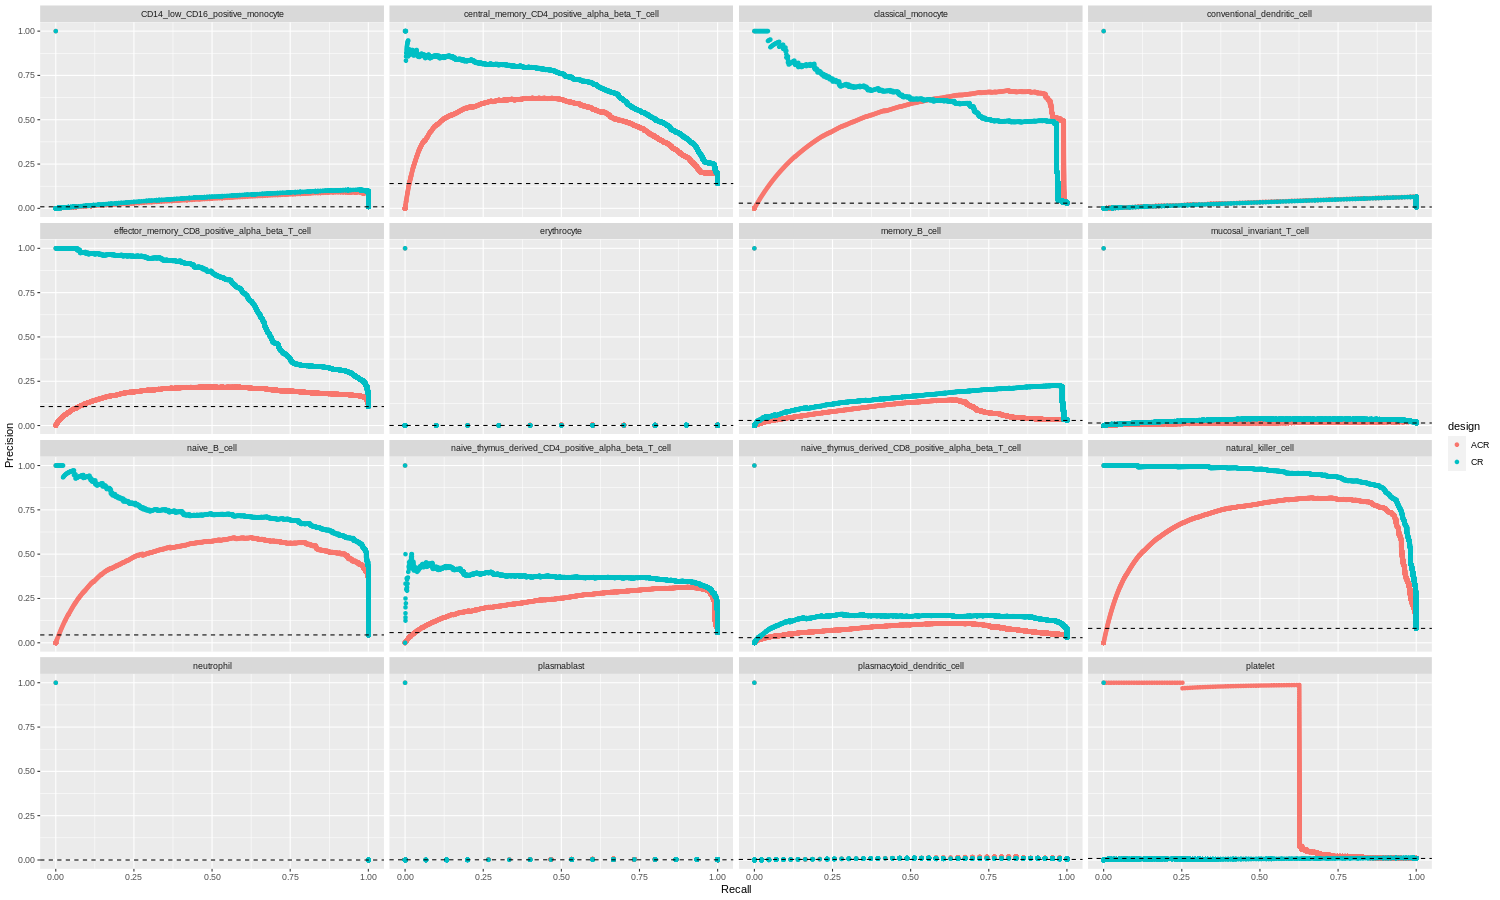

In [101]:
%%R -w 1500 -h 900
meld_auprc_df %>%
ggplot(aes(Recall,Precision, color=design)) +
geom_point() +
geom_hline(data=. %>% group_by(OOR_state_name, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(OOR_state_name~.)

In [17]:
from sklearn.metrics import auc, precision_recall_curve

def _auprc(oor_results, return_curve: bool = False):
    """Calculate area under precision-recall curve for OOR state detection.

    This metric doesn't use the significance/confidence of the OOR state prediction

    Parameters:
    -----------
    oor_results: AnnData or DataFrame
        AnnData object after running method (storing results in oor_results.uns['sample_adata'].var) or DataFrame of results
    return_curve: bool
        Return precision-recall curve (default: False)

    Returns:
    --------
    DataFrame storing AUPRC and no-skill threshold, if return_curve is False
    DataFrame of precision, recall, AUPRC and no-skill threshold, if return_curve is True
    """
    if isinstance(oor_results, AnnData):
        if "OOR_state_group" not in _get_sample_adata(oor_results).var:
            make_OOR_per_group(oor_results)

        out_df = _get_sample_adata(oor_results).var[["OOR_score", "OOR_state_group"]]
    else:
        out_df = oor_results.copy()
    precision, recall, _ = precision_recall_curve(out_df.OOR_state_group, out_df.OOR_score)
    no_skill = sum(out_df.OOR_state_group) / out_df.shape[0]
    AUC = auc(recall, precision)
    if return_curve:
        AUPRC_df = pd.DataFrame(np.vstack([recall, precision]), index=["Recall", "Precision"]).T
        AUPRC_df["AUPRC"] = AUC
        AUPRC_df["no_skill_thresh"] = no_skill
    else:
        AUPRC_df = pd.DataFrame(index=["AUPRC", "no_skill_thresh"]).T
        AUPRC_df.loc[0, "AUPRC"] = AUC
        AUPRC_df.loc[0, "no_skill_thresh"] = no_skill
    return AUPRC_df

In [32]:
auprc.auprc(acr_adata)

,AUPRC,no_skill_thresh
0,0.076857,0.028777


In [19]:
adata.uns['sample_adata'].var

,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,sample_id,donor_id,dataset_id,development_stage,...,is_train,is_test,is_ctrl,dataset_group,OOR_state,cell_annotation,Site,is_query,OOR_score,OOR_signif
10_1038_s41591_021_01329_2-BGCV01_GACCTGGGTAAGCACG-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV01_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,natural_killer_cell,CV0,False,0.523447,False
10_1038_s41591_021_01329_2-TTGGAACCATGGTCTA-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,classical_monocyte,MH8,False,0.384673,False
10_1038_s41591_021_01329_2-AGGCCGTTCGCTTAGA-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,memory_B_cell,MH8,False,0.471647,False
10_1038_s41591_021_01329_2-AAGACCTGTTTGACAC-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,memory_B_cell,MH8,False,0.474263,False
10_1038_s41591_021_01329_2-TAGTTGGCATAACCTG-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,central_memory_CD4_positive_alpha_beta_T_cell,MH8,False,0.531272,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_1038_s41591_021_01329_2-BGCV04_CAAGTTGGTGCTAGCC-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,naive_thymus_derived_CD4_positive_alpha_beta_T...,CV0,True,0.536789,False
10_1038_s41591_021_01329_2-BGCV04_CTTTGCGAGTGCAAGC-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,natural_killer_cell,CV0,True,0.520313,False
10_1038_s41591_021_01329_2-BGCV04_ATCCGAAGTTCCGTCT-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,natural_killer_cell,CV0,True,0.520036,False
10_1038_s41591_021_01329_2-BGCV04_GCAATCAAGCGTAATA-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,memory_B_cell,CV0,True,0.474481,False


In [51]:
def read_oor_design_output(simdir, ref_design, embedding_method, diff_method, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.{embedding_method}_{diff_method}.h5ad'
    if diff_method == 'milo':
        try:
            adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=True)
        except:
            print(f'skipping {ref_design} design')
            return(None)
    else:
        try:
            adata = sc.read_h5ad(h5ad_file, backed=True)
        except:
            print(f'skipping {ref_design} design')
            return(None)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

In [190]:
adata_design = acr_adata
query_group='query'
reference_group='ctrl'
query_samples = adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == query_group].unique().tolist()
reference_samples = (
    adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == reference_group].unique().tolist()
)

In [52]:
import scipy.stats
def _run_wilcoxon(example_acr, OOR_state):
    query_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'query')]['sample_density'].values
    ctrl_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'ctrl')]['sample_density'].values
    return(scipy.stats.ranksums(query_densities, ctrl_densities))

def _run_ttest(example_acr, OOR_state):
    query_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'query')]['sample_density'].values
    ctrl_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'ctrl')]['sample_density'].values
    return(scipy.stats.ttest_ind(query_densities, ctrl_densities))

In [336]:
def _get_example_densities(adata_design, sample_OOR, sample_InR):
    df1 = adata_design[sample_OOR].obsm["sample_densities"].melt(var_name='sample_id', value_name='sample_density')
    df1['OOR_state'] = 1
    df1['dataset_group'] = np.where(df1['sample_id'].isin(query_samples), 'query', 'ctrl')

    df0 = adata_design[sample_InR].obsm["sample_densities"].melt(var_name='sample_id', value_name='sample_density')
    df0['OOR_state'] = 0
    df0['dataset_group'] = np.where(df0['sample_id'].isin(query_samples), 'query', 'ctrl')

    df = pd.concat([df0, df1])
    return(df)

sample_OOR = np.random.choice(acr_adata.obs_names[acr_adata.obs['OOR_state'] == 1], size=1, replace=False)
sample_InR = np.random.choice(acr_adata.obs_names[acr_adata.obs['OOR_state'] == 0], size=1, replace=False)

example_acr = _get_example_densities(acr_adata, sample_OOR, sample_InR)
example_acr['design'] = 'ACR'
example_cr = _get_example_densities(cr_adata, sample_OOR, sample_InR)
example_cr['design'] = 'CR'
df = pd.concat([example_acr, example_cr])

In [337]:
%%R -i df
head(df)

      sample_id sample_density OOR_state dataset_group design
1 BGCV01_CV0902   6.941661e-05         0          ctrl    ACR
2 BGCV01_CV0904   8.716548e-05         0         query    ACR
3 BGCV02_CV0902   8.269804e-05         0          ctrl    ACR
4 BGCV04_CV0911   8.160811e-05         0         query    ACR
5 BGCV05_CV0929   7.245277e-05         0          ctrl    ACR
6 BGCV08_CV0915   8.098880e-05         0          ctrl    ACR


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


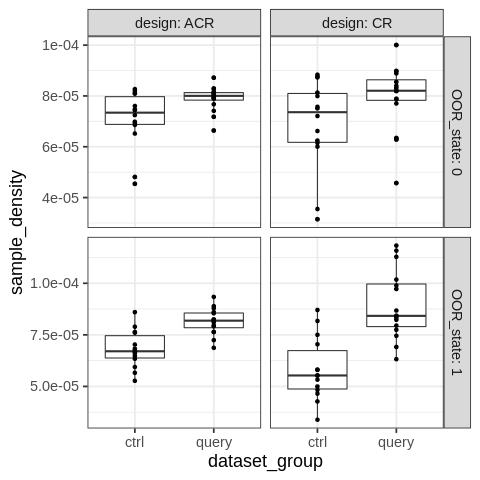

In [338]:
%%R
df %>%
ggplot(aes(dataset_group,sample_density)) +
geom_boxplot() +
geom_point(width=0.1) +
theme_bw(base_size=18) +
facet_grid(OOR_state~design, labeller='label_both', scales='free_y')

In [339]:
example_cr.groupby(['OOR_state', 'dataset_group']).mean()

/tmp/ipykernel_4407/2343792231.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  example_cr.groupby(['OOR_state', 'dataset_group']).mean()


sample_density
OOR_state dataset_group                
0         ctrl                 0.000069
          query                0.000080
1         ctrl                 0.000058
          query                0.000089

In [340]:
example_acr.groupby(['OOR_state', 'dataset_group']).mean()

/tmp/ipykernel_4407/4160328046.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  example_acr.groupby(['OOR_state', 'dataset_group']).mean()


sample_density
OOR_state dataset_group                
0         ctrl                 0.000071
          query                0.000079
1         ctrl                 0.000068
          query                0.000081

In [341]:
def _get_meld(example_cr, OOR_state):
    mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()
    probs = normalize(mean_density[mean_density['OOR_state'] == OOR_state]['sample_density'].values.reshape(1,-1), norm='l1')
    return(probs)

In [342]:
print(_get_meld(example_cr, 0))
print(_get_meld(example_cr, 1))

[[0.46395871 0.53604129]]
[[0.39477835 0.60522165]]


/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()
/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()


In [343]:
print(_get_meld(example_acr, 0))
print(_get_meld(example_acr, 1))

[[0.47257977 0.52742023]]
[[0.4551933 0.5448067]]


/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()
/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()


In [344]:
print(_run_wilcoxon(example_acr, 0))
print(_run_wilcoxon(example_acr, 1))

RanksumsResult(statistic=2.120098032686877, pvalue=0.03399777884079311)
RanksumsResult(statistic=3.74134946944743, pvalue=0.00018303479550820938)


In [345]:
print(_run_ttest(example_acr, 0))
print(_run_ttest(example_acr, 1))

Ttest_indResult(statistic=2.5990695443160696, pvalue=0.01474800571404792)
Ttest_indResult(statistic=4.78673535604674, pvalue=4.968528925947287e-05)


In [346]:
print(_run_wilcoxon(example_cr, 0))
print(_run_wilcoxon(example_cr, 1))

RanksumsResult(statistic=2.036956933365823, pvalue=0.041654357952089036)
RanksumsResult(statistic=3.824490568768484, pvalue=0.0001310427619889688)


In [347]:
print(_run_ttest(example_cr, 0))
print(_run_ttest(example_cr, 1))

Ttest_indResult(statistic=1.9004088405369761, pvalue=0.06772099088723575)
Ttest_indResult(statistic=5.33667493396452, pvalue=1.1054918695695874e-05)


In [370]:
pd.concat([acr_adata.obs, pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])], 1)

/tmp/ipykernel_4407/4225038744.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([acr_adata.obs, pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/core/formatters.py:343: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,sample_id,donor_id,dataset_id,development_stage,...,is_test,is_ctrl,dataset_group,OOR_state,cell_annotation,Site,is_query,OOR_state_name,wilcox_pval,wilcox_stat
10_1038_s41591_021_01329_2-BGCV02_TGCGGGTTCAGCTCTC-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,effector_memory_CD8_positive_alpha_beta_T_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_GCAGCCAGTTGCGTTA-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,effector_memory_CD8_positive_alpha_beta_T_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_TCATTACGTCAGGACA-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,naive_B_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_AAGGTTCGTTGTGGCC-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,central_memory_CD4_positive_alpha_beta_T_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_CCCAATCAGGCCGAAT-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,naive_thymus_derived_CD8_positive_alpha_beta_T...,CV0,False,natural_killer_cell,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002762,2.993080
13172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405741,-0.831411
13173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080817,1.745963
13174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339010,-0.956123


In [401]:
def _run_stats_comparison(acr_adata, cr_adata):
    # Get sample ids
    adata_design = acr_adata
    query_group='query'
    reference_group='ctrl'
    query_samples = adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == query_group].unique().tolist()
    reference_samples = (
        adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == reference_group].unique().tolist()
    )

    pvals = []
    statistics = []
    for i,c in acr_adata.obsm['sample_densities'].iterrows():
        statistic, pval = scipy.stats.ranksums(c[query_samples].values, c[reference_samples].values)
        pvals.append(pval)
        statistics.append(statistic)

    wilcox_df = pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])
    wilcox_df.index = acr_adata.obs_names
    acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)

    pvals = []
    statistics = []
    for i,c in cr_adata.obsm['sample_densities'].iterrows():
        statistic, pval = scipy.stats.ranksums(c[query_samples].values, c[reference_samples].values)
        pvals.append(pval)
        statistics.append(statistic)

    wilcox_df = pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])
    wilcox_df.index = cr_adata.obs_names
    cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)

    acr_adata.obs['meld_probability'] = acr_adata.uns['sample_adata'].var['OOR_score']
    cr_adata.obs['meld_probability'] = cr_adata.uns['sample_adata'].var['OOR_score']

    acr_adata.uns['sample_adata'].var['OOR_score'] = acr_adata.obs['wilcox_stat'].copy()
    cr_adata.uns['sample_adata'].var['OOR_score'] = cr_adata.obs['wilcox_stat'].copy()
    acr_auprc_df = auprc.auprc(acr_adata, return_curve=True)
    acr_auprc_df['design'] = 'ACR'
    acr_auprc_df['stat'] = 'wilcox'
    cr_auprc_df = auprc.auprc(cr_adata, return_curve=True)
    cr_auprc_df['design'] = 'CR'
    cr_auprc_df['stat'] = 'wilcox'
    auprc_df_wilcox = pd.concat([acr_auprc_df,cr_auprc_df])

    acr_adata.uns['sample_adata'].var['OOR_score'] = acr_adata.obs['meld_probability'].copy()
    cr_adata.uns['sample_adata'].var['OOR_score'] = cr_adata.obs['meld_probability'].copy()
    acr_auprc_df = auprc.auprc(acr_adata, return_curve=True)
    acr_auprc_df['design'] = 'ACR'
    acr_auprc_df['stat'] = 'prob'
    cr_auprc_df = auprc.auprc(cr_adata, return_curve=True)
    cr_auprc_df['design'] = 'CR'
    cr_auprc_df['stat'] = 'prob'
    auprc_df_prob = pd.concat([acr_auprc_df,cr_auprc_df])

    AUPRC_compare = pd.concat([auprc_df_prob, auprc_df_wilcox])
    return(AUPRC_compare)

In [396]:
%%R -i AUPRC_compare
head(AUPRC_compare)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision     AUPRC no_skill_thresh design stat
1      1 0.08098057 0.6734793      0.08098057    ACR prob
2      1 0.08098672 0.6734793      0.08098057    ACR prob
3      1 0.08099286 0.6734793      0.08098057    ACR prob
4      1 0.08099901 0.6734793      0.08098057    ACR prob
5      1 0.08100516 0.6734793      0.08098057    ACR prob
6      1 0.08101131 0.6734793      0.08098057    ACR prob


`summarise()` has grouped output by 'stat'. You can override using the `.groups` argument.


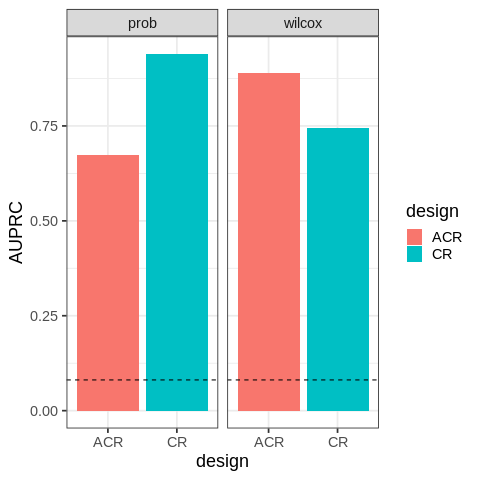

In [400]:
%%R 
AUPRC_compare %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(stat, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(stat~., nrow=1) +
theme_bw(base_size=18)

In [53]:
acr_adata = read_oor_design_output(simdir, 'ACR', embedding_method='scArches', diff_method='meld', population_obs = 'cell_type')

Reading CD14_low_CD16_positive_monocyte



In [74]:
pd.concat([s_obs, pd.Series(s_obs_i)])

0      10_1038_s41591_021_01329_2-TGGGAAGGTATAGTAG-MH...
1      10_1038_s41591_021_01329_2-CATGGCGAGACAAGCC-MH...
2      10_1038_s41591_021_01329_2-ACATGGTCATCAGTCA-MH...
3      10_1038_s41591_021_01329_2-AAAGTAGTCCTGCTTG-MH...
4      10_1038_s41591_021_01329_2-GTGCGGTGTCTCATCC-MH...
                             ...                        
414    10_1038_s41591_021_01329_2-ATCATGGTCCGCGTTT-MH...
415    10_1038_s41591_021_01329_2-TGACGGCAGAGGTAGA-MH...
416    10_1038_s41591_021_01329_2-TCGTACCAGCAATATG-MH...
417    10_1038_s41591_021_01329_2-ACTTGTTCACCTGGTG-MH...
418    10_1038_s41591_021_01329_2-TTGACTTTCATCTGTT-MH...
Length: 419, dtype: object

In [80]:
s_obs_i

(419,)

In [85]:
adata = acr_adata
n_cells_sample = 300
s_obs = pd.Series() 
for s in adata.obs['sample_id'].unique():
    s_obs_i = adata.obs_names[adata.obs['sample_id'] == s]
    if s_obs_i.shape[0] > n_cells_sample:
        obs_df = adata.obs.loc[s_obs_i]
        obs_df['sample_id'] = obs_df['sample_id'].astype('str')
        s_obs_i = obs_df[['sample_id']].groupby(
            'sample_id').sample(n_cells_sample).index
    s_obs = pd.concat([s_obs, pd.Series(s_obs_i)])
s_obs = s_obs.values

/tmp/ipykernel_4160/3650631419.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s_obs = pd.Series()


In [403]:
stat_comparison_result = pd.DataFrame()
for d in dirs:
    print(d)
    simdir = outdir + d
    acr_adata = read_oor_design_output(simdir, 'ACR', embedding_method='scArches', diff_method='meld', population_obs = 'cell_type')
    cr_adata = read_oor_design_output(simdir, 'CR', embedding_method='scArches', diff_method='meld', population_obs = 'cell_type')
    AUPRC_df = _run_stats_comparison(acr_adata=acr_adata, cr_adata=cr_adata)
    AUPRC_df['OOR_state_name'] = acr_adata.obs['OOR_state_name'].unique()[0]
    stat_comparison_result = pd.concat([stat_comparison_result, AUPRC_df])

qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading memory_B_cell

Reading memory_B_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading conventional_dendritic_cell

Reading conventional_dendritic_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading naive_B_cell

Reading naive_B_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading central_memory_CD4_positive_alpha_beta_T_cell

Reading central_memory_CD4_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading plasmablast

Reading plasmablast



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeneutrophil_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading neutrophil

Reading neutrophil



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_t

qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading platelet

Reading platelet



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading plasmacytoid_dendritic_cell

Reading plasmacytoid_dendritic_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell

Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading classical_monocyte

Reading classical_monocyte



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading erythrocyte

Reading erythrocyte



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell

Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading natural_killer_cell

Reading natural_killer_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading effector_memory_CD8_positive_alpha_beta_T_cell

Reading effector_memory_CD8_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading mucosal_invariant_T_cell

Reading mucosal_invariant_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading CD14_low_CD16_positive_monocyte

Reading CD14_low_CD16_positive_monocyte



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


In [407]:
stat_comparison_result

,Recall,Precision,AUPRC,no_skill_thresh,design,stat,OOR_state_name
0,1.0,0.028836,0.080583,0.028836,ACR,prob,memory_B_cell
1,1.0,0.028838,0.080583,0.028836,ACR,prob,memory_B_cell
2,1.0,0.028841,0.080583,0.028836,ACR,prob,memory_B_cell
3,1.0,0.028843,0.080583,0.028836,ACR,prob,memory_B_cell
4,1.0,0.028845,0.080583,0.028836,ACR,prob,memory_B_cell
...,...,...,...,...,...,...,...
88,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte
89,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte
90,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte
91,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte


In [408]:
%%R -i stat_comparison_result
head(stat_comparison_result)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision      AUPRC no_skill_thresh design stat OOR_state_name
1      1 0.02883640 0.08058341       0.0288364    ACR prob  memory_B_cell
2      1 0.02883849 0.08058341       0.0288364    ACR prob  memory_B_cell
3      1 0.02884058 0.08058341       0.0288364    ACR prob  memory_B_cell
4      1 0.02884267 0.08058341       0.0288364    ACR prob  memory_B_cell
5      1 0.02884476 0.08058341       0.0288364    ACR prob  memory_B_cell
6      1 0.02884685 0.08058341       0.0288364    ACR prob  memory_B_cell


`summarise()` has grouped output by 'stat'. You can override using the `.groups` argument.


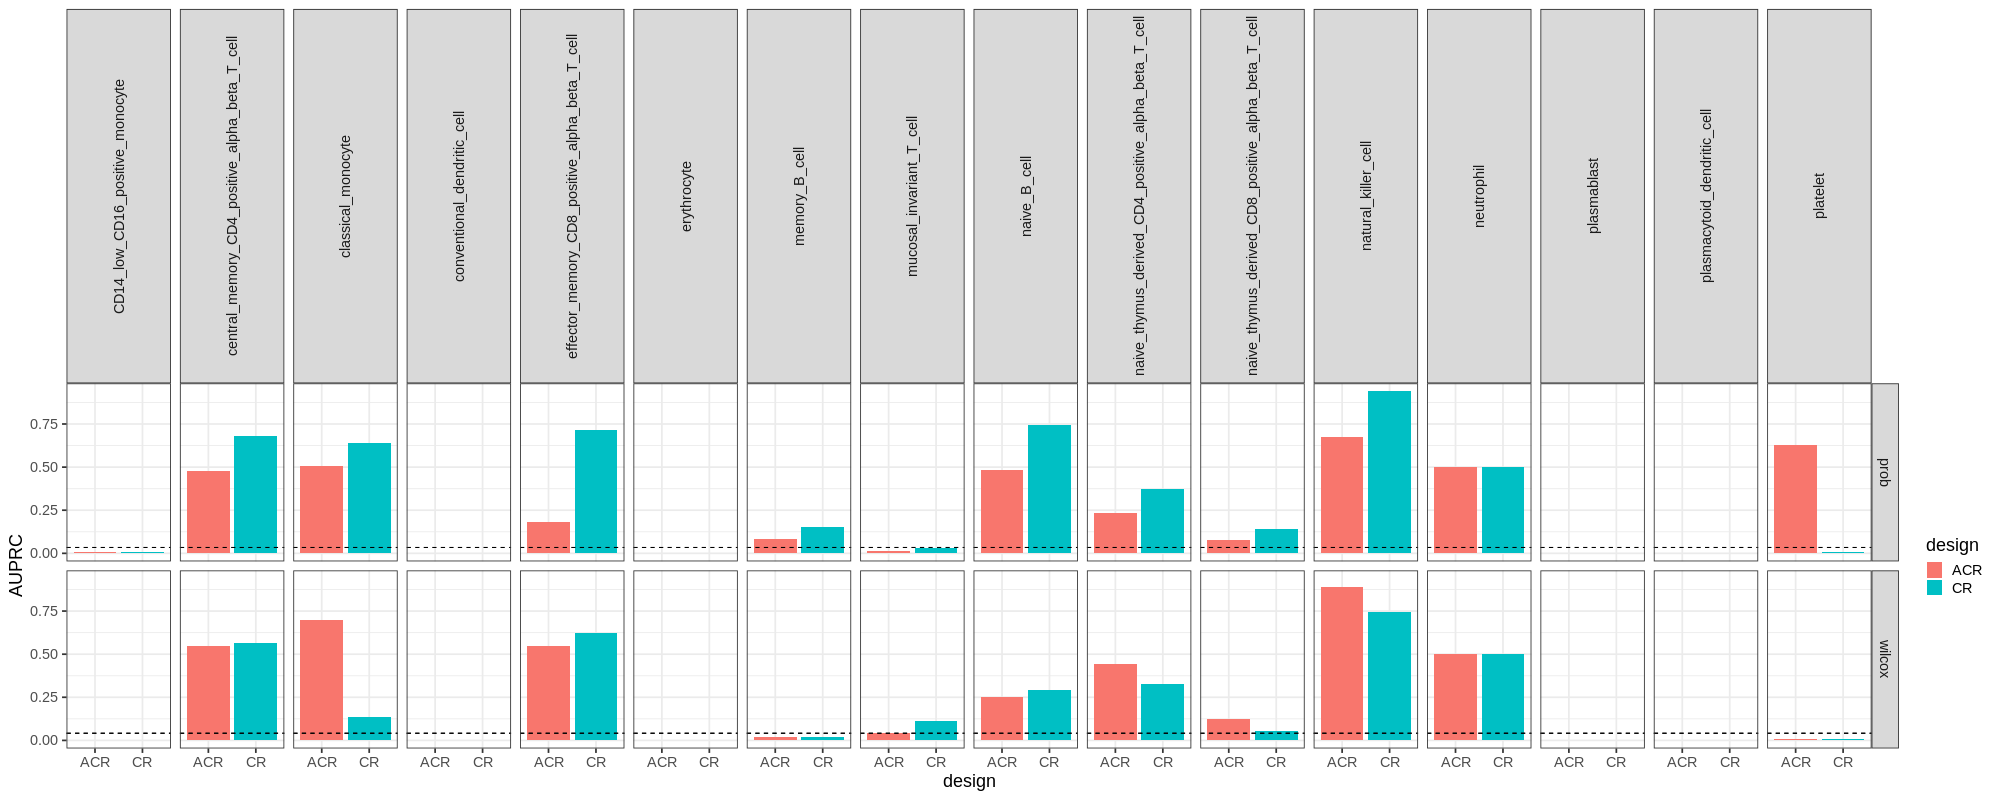

In [416]:
%%R -h 800 -w 2000
stat_comparison_result %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(stat, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_grid(stat~OOR_state_name) +
theme_bw(base_size=18) +
theme(strip.text.x=element_text(angle=90))

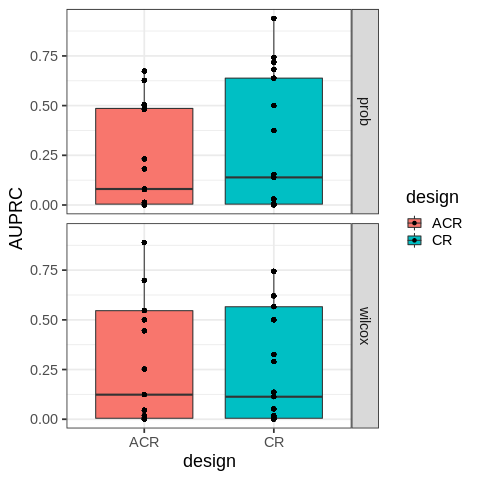

In [417]:
%%R 
stat_comparison_result %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_boxplot() +
geom_point() +
facet_grid(stat~.) +
theme_bw(base_size=18) +
theme(strip.text.x=element_text(angle=90))

### CNA

In [20]:
from anndata import AnnData
from multianndata import MultiAnnData
import cna

def run_cna(adata: AnnData, query_group: str, reference_group: str, sample_col: str = "sample_id"):
    """
    Run MELD to compute probability estimate per condition.

    Following tutorial in https://nbviewer.org/github/yakirr/cna/blob/master/demo/demo.ipynb

    Parameters:
    ------------
    adata : AnnData
        AnnData object of disease and reference cells to compare
    query_group : str
        Name of query group in adata_design.obs['dataset_group']
    reference_group : str
        Name of reference group in adata_design.obs['dataset_group']
    sample_col : str
        Name of column in adata_design.obs to use as sample ID
    """
    adata_design = MultiAnnData(adata, sampleid=sample_col)
    adata_design.obs["dataset_group"] = adata_design.obs["dataset_group"].astype("category")
    adata_design.obs["dataset_group_code"] = (
        adata_design.obs["dataset_group"].cat.reorder_categories([reference_group, query_group]).cat.codes
    )
    adata_design.obs_to_sample(["dataset_group_code"])
    res = cna.tl.association(adata_design, adata_design.samplem.dataset_group_code, ks=[20, 25])
    adata.obs["CNA_ncorrs"] = res.ncorrs
    return None

## quick re-run CNA
from scipy.sparse import csc_matrix

def _fastCNA(simdir, design, signif_quantile=0.9):    
    emb_reference_assignment = {
        "ACR":'atlas',
        "AR":'atlas',
        "CR":'ctrl',
    }

    diff_reference_assignment = {
        "ACR":'ctrl',
        "AR":'atlas',
        "CR":'ctrl',    
    }
    adata = sc.read_h5ad(simdir + f'/{design.lower()}_design.h5ad', backed=True)
    run_cna(adata, query_group='query', reference_group=diff_reference_assignment[design])

    sample_adata = AnnData(var=adata.obs)
    sample_adata.var["OOR_score"] = sample_adata.var["CNA_ncorrs"]
    quant_10perc = np.quantile(sample_adata.var["OOR_score"], signif_quantile)
    sample_adata.var["OOR_signif"] = sample_adata.var["OOR_score"] >= quant_10perc
    sample_adata.varm["groups"] = csc_matrix(np.identity(sample_adata.n_vars))
    adata.uns["sample_adata"] = sample_adata.copy()
    embedding_method = 'scArches'
    diff_method = 'cna'
    h5ad_path = simdir + f'/{design}_design.{embedding_method}_{diff_method}.h5ad'
    adata.write_h5ad(h5ad_path)

In [21]:
for d in dirs:
    for design in ['ACR', 'CR']:
        print(d)
        simdir = outdir + d
        _fastCNA(simdir, design=design)

qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.990419631159884
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.301497399627948
	20th percentile R2(t,t-1): 0.8244351148605347
	taking step 3
	median kurtosis: 4.5784666717572176
	20th percentile R2(t,t-1): 0.9477665662765503
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.192501537658574
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.475370574898218
	20th percentile R2(t,t-1): 0.809487771987915
	taking step 3
	median kurtosis: 4.8028351994710725
	20th percentile R2(t,t-1): 0.9325987696647644
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.69977354638925
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.02562008174165
	20th percentile R2(t,t-1): 0.813276493549347
	taking step 3
	median kurtosis: 4.36796699291774
	20th percentile R2(t,t-1): 0.94505215883255
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.110335332171616
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.396240602672518
	20th percentile R2(t,t-1): 0.8132259607315063
	taking step 3
	median kurtosis: 4.712505876466619
	20th percentile R2(t,t-1): 0.9373624444007873
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.114944340042286
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.410723821980614
	20th percentile R2(t,t-1): 0.8250740885734558
	taking step 3
	median kurtosis: 4.707141550019049
	20th percentile R2(t,t-1): 0.9504112601280212
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.157246504245821
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.367015824630913
	20th percentile R2(t,t-1): 0.8030716776847839
	taking step 3
	median kurtosis: 4.625915493157545
	20th percentile R2(t,t-1): 0.92667635679245
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.325557166045
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.658255928730953
	20th percentile R2(t,t-1): 0.8366420269012451
	taking step 3
	median kurtosis: 4.944873471127691
	20th percentile R2(t,t-1): 0.9539097428321839
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.149602637481987
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.282437985318773
	20th percentile R2(t,t-1): 0.8018902897834778
	taking step 3
	median kurtosis: 4.5978440183184
	20th percentile R2(t,t-1): 0.9351725935935974
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.01354404672884
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.322134413328617
	20th percentile R2(t,t-1): 0.8191625237464905
	taking step 3
	median kurtosis: 4.60631488268229
	20th percentile R2(t,t-1): 0.9495443820953369
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.135293020898435
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.4615317639321095
	20th percentile R2(t,t-1): 0.8110948801040649
	taking step 3
	median kurtosis: 4.728471541214696
	20th percentile R2(t,t-1): 0.9368863224983215
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeneutrophil_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.755589679768335
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.005178760034662
	20th percentile R2(t,t-1): 0.8142419695854187
	taking step 3
	median kurtosis: 4.368262979110799
	20th percentile R2(t,t-1): 0.9446450233459472
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeneutrophil_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.95114697308505
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.301085745937704
	20th percentile R2(t,t-1): 0.8111320972442627
	taking step 3
	median kurtosis: 4.638828472347111
	20th percentile R2(t,t-1): 0.9352119922637939
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.055457885360603
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.46507892568282
	20th percentile R2(t,t-1): 0.824761152267456
	taking step 3
	median kurtosis: 4.814725166307186
	20th percentile R2(t,t-1): 0.9503018260002136
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:57: UserWarning: data supported use of 25 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  warnings.warn(('data supported use of {} NAM PCs, which is the maximum considered. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.282660216739685
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.572582295732946
	20th percentile R2(t,t-1): 0.8146315932273864
	taking step 3
	median kurtosis: 4.806836610473967
	20th percentile R2(t,t-1): 0.9387180209159851
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.072967631409923
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.326571140752187
	20th percentile R2(t,t-1): 0.8248553156852723
	taking step 3
	median kurtosis: 4.672155384263392
	20th percentile R2(t,t-1): 0.9497406601905822
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.016882886236618
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.2699031598184405
	20th percentile R2(t,t-1): 0.8141600251197815
	taking step 3
	median kurtosis: 4.625843644690275
	20th percentile R2(t,t-1): 0.9416281461715699
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.001122281961496
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.383975632952188
	20th percentile R2(t,t-1): 0.8237492322921753
	taking step 3
	median kurtosis: 4.717590985819639
	20th percentile R2(t,t-1): 0.946213161945343
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.0399783061279875
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.317431643856526
	20th percentile R2(t,t-1): 0.8219650149345398
	taking step 3
	median kurtosis: 4.6238524026437275
	20th percentile R2(t,t-1): 0.9431335806846619
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.633532145291336
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 4.908491712199507
	20th percentile R2(t,t-1): 0.8130783915519715
	taking step 3
	median kurtosis: 4.1692966417428
	20th percentile R2(t,t-1): 0.9427960753440857
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.289047930365962
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.395232265172554
	20th percentile R2(t,t-1): 0.8130989313125611
	taking step 3
	median kurtosis: 4.591863681863443
	20th percentile R2(t,t-1): 0.9333473086357117
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.907260093881437
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.239974438416012
	20th percentile R2(t,t-1): 0.8235144734382629
	taking step 3
	median kurtosis: 4.571878730012902
	20th percentile R2(t,t-1): 0.9500961899757385
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:57: UserWarning: data supported use of 25 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  warnings.warn(('data supported use of {} NAM PCs, which is the maximum considered. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.048258072845589
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.323684366215349
	20th percentile R2(t,t-1): 0.8119603276252747
	taking step 3
	median kurtosis: 4.605559403867975
	20th percentile R2(t,t-1): 0.9343042850494385
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.96466947561614
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.2805777268579694
	20th percentile R2(t,t-1): 0.8304237365722656
	taking step 3
	median kurtosis: 4.571479404031953
	20th percentile R2(t,t-1): 0.9501535654067993
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:57: UserWarning: data supported use of 25 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  warnings.warn(('data supported use of {} NAM PCs, which is the maximum considered. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.081347100551039
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.2785580150502875
	20th percentile R2(t,t-1): 0.8089399218559266
	taking step 3
	median kurtosis: 4.581529213161274
	20th percentile R2(t,t-1): 0.9350290060043335
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.177055721375939
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.306981383816436
	20th percentile R2(t,t-1): 0.8297534108161926
	taking step 3
	median kurtosis: 4.525083584325367
	20th percentile R2(t,t-1): 0.9521631002426147
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.451916718536758
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.685666732866864
	20th percentile R2(t,t-1): 0.8267986536026001
	taking step 3
	median kurtosis: 4.936004596095449
	20th percentile R2(t,t-1): 0.9421902656555176
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.9410504310890335
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.222894883418708
	20th percentile R2(t,t-1): 0.8266027212142945
	taking step 3
	median kurtosis: 4.585248576799199
	20th percentile R2(t,t-1): 0.9529350996017456
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:57: UserWarning: data supported use of 25 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  warnings.warn(('data supported use of {} NAM PCs, which is the maximum considered. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.3392523167944885
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.430299981388906
	20th percentile R2(t,t-1): 0.8147334337234498
	taking step 3
	median kurtosis: 4.638955228696146
	20th percentile R2(t,t-1): 0.938348114490509
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 6.908055762498105
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.188853552172599
	20th percentile R2(t,t-1): 0.8278297424316406
	taking step 3
	median kurtosis: 4.533642018998016
	20th percentile R2(t,t-1): 0.949726688861847
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.11923368933807
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.456153326421786
	20th percentile R2(t,t-1): 0.8108984589576721
	taking step 3
	median kurtosis: 4.70250465057153
	20th percentile R2(t,t-1): 0.9341913223266601
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.014442124761446
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.302085796589074
	20th percentile R2(t,t-1): 0.823635745048523
	taking step 3
	median kurtosis: 4.542866636826018
	20th percentile R2(t,t-1): 0.9496459245681763
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs
qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
['sex' 'tissue' 'ethnicity' 'disease' 'assay' 'assay_ontology_term_id'
 'sample_id' 'donor_id' 'dataset_id' 'development_stage' 'cell_type'
 'leiden' 'cell_type_leiden' 'dataset_group' 'cell_annotation' 'Site']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 7.092115715710772
	20th percentile R2(t,t-1): nan
	taking step 2
	median kurtosis: 5.218048255154891
	20th percentile R2(t,t-1): 0.8082149028778076
	taking step 3
	median kurtosis: 4.455359744829139
	20th percentile R2(t,t-1): 0.9341284275054932
stopping after 3 steps
covariate-adjusted NAM not found; computing and saving
computing SVD
performing association test


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:79: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/cna/tools/_nam.py:101: UserWarning: only one unique batch supplied to prep
  warnings.warn('only one unique batch supplied to prep')


computing neighborhood-level FDRs


In [22]:
cna_nhood_df = pd.DataFrame()
for d in dirs:
    nhood_obs_df = pd.read_csv(outdir + d + '/nhoods_obs.scArches_cna.csv', index_col=0)
    cna_nhood_df = pd.concat([cna_nhood_df, nhood_obs_df])

In [23]:
%%R -i cna_nhood_df
head(cna_nhood_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


   sex tissue ethnicity disease                          assay
1 male  blood   unknown  normal 10x 3' transcription profiling
2 male  blood   unknown  normal 10x 3' transcription profiling
3 male  blood   unknown  normal 10x 3' transcription profiling
4 male  blood   unknown  normal 10x 3' transcription profiling
5 male  blood   unknown  normal 10x 3' transcription profiling
6 male  blood   unknown  normal 10x 3' transcription profiling
  assay_ontology_term_id sample_id  donor_id                 dataset_id
1            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
2            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
3            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
4            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
5            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
6            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
          development_stage                       cell_

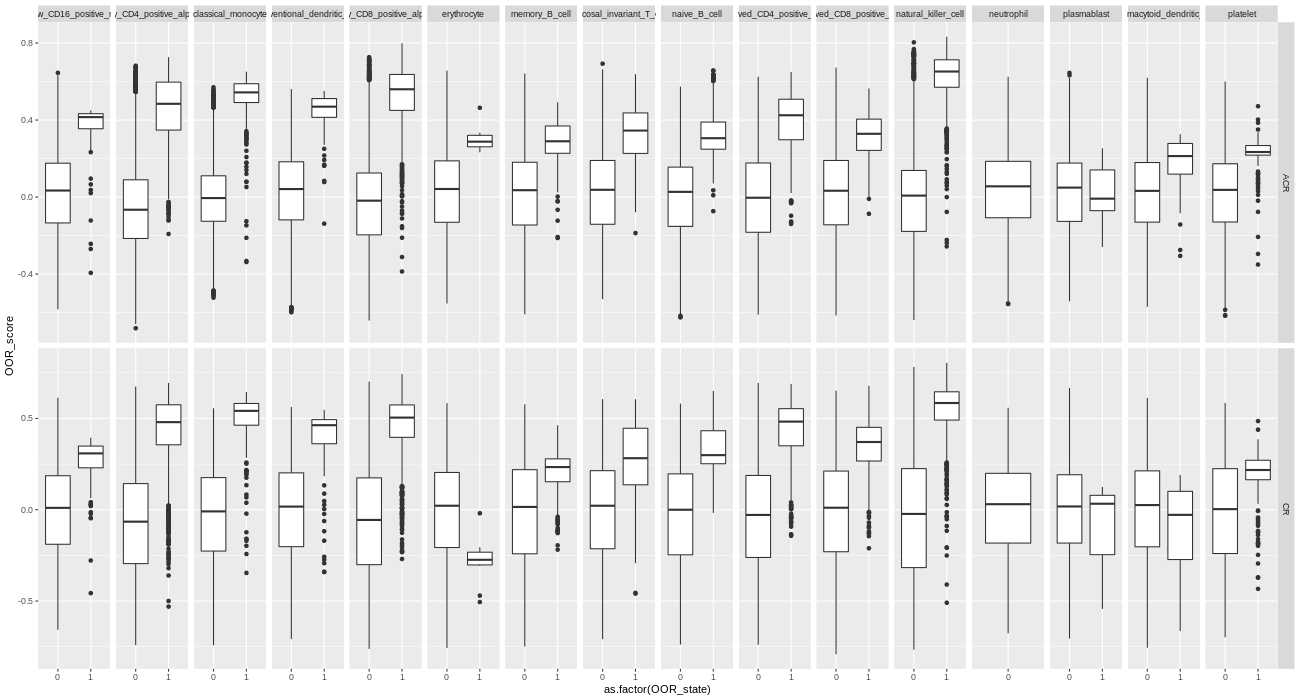

In [24]:
%%R -w 1300 -h 700
cna_nhood_df %>%
ggplot(aes(as.factor(OOR_state), OOR_score)) +
geom_boxplot() +
# geom_jitter() +
facet_grid(design~OOR_state_name, scales='free')

In [25]:
cna_auprc_df = pd.DataFrame()
for ct in cna_nhood_df['OOR_state_name'].unique():
    for d in cna_nhood_df['design'].unique():
        auprc_df = auprc.auprc(cna_nhood_df[(cna_nhood_df['OOR_state_name'] == ct) & (cna_nhood_df['design'] == d)], return_curve=True)
        auprc_df['design'] = d
        auprc_df['OOR_state_name'] = ct
        cna_auprc_df = pd.concat([cna_auprc_df, auprc_df])

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [26]:
%%R -i cna_auprc_df
head(cna_auprc_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision     AUPRC no_skill_thresh design OOR_state_name
1      1 0.02883640 0.1264372       0.0288364    ACR  memory_B_cell
2      1 0.02883849 0.1264372       0.0288364    ACR  memory_B_cell
3      1 0.02884058 0.1264372       0.0288364    ACR  memory_B_cell
4      1 0.02884267 0.1264372       0.0288364    ACR  memory_B_cell
5      1 0.02884476 0.1264372       0.0288364    ACR  memory_B_cell
6      1 0.02884685 0.1264372       0.0288364    ACR  memory_B_cell


`summarise()` has grouped output by 'OOR_state_name'. You can override using
the `.groups` argument.


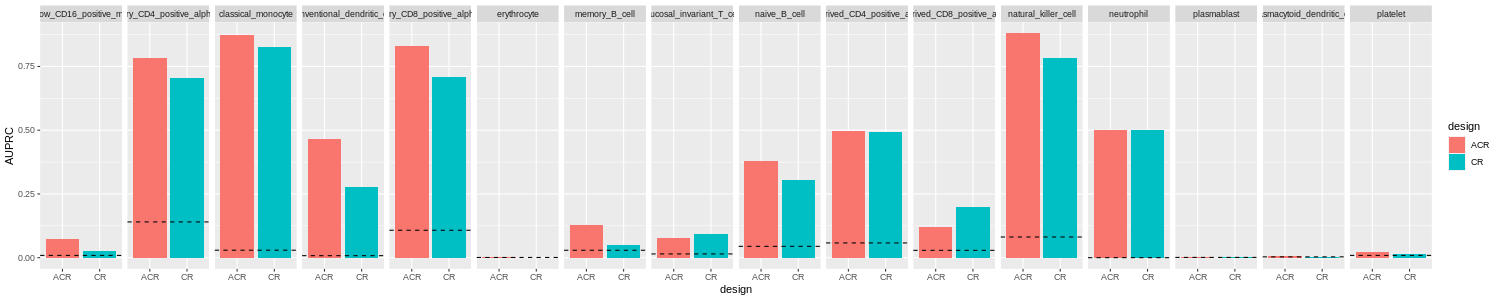

In [27]:
%%R -w 1500 -h 300
cna_auprc_df %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(OOR_state_name, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(OOR_state_name~., nrow=1)

In [36]:
cna_auprc_df.groupby('OOR_state_name').mean()

/tmp/ipykernel_4160/3766359923.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cna_auprc_df.groupby('OOR_state_name').mean()


,Recall,Precision,AUPRC,no_skill_thresh
OOR_state_name,,,,
CD14_low_CD16_positive_monocyte,0.863290,0.021698,0.049495,0.008896
central_memory_CD4_positive_alpha_beta_T_cell,0.880962,0.369082,0.743529,0.140029
classical_monocyte,0.959458,0.124529,0.848614,0.029242
conventional_dendritic_cell,0.922528,0.034163,0.369886,0.007693
effector_memory_CD8_positive_alpha_beta_T_cell,0.906012,0.313775,0.771075,0.107260
erythrocyte,0.539431,0.000959,0.001599,0.000707
memory_B_cell,0.796755,0.056684,0.088138,0.028836
mucosal_invariant_T_cell,0.808768,0.036151,0.084438,0.014575
naive_B_cell,0.882051,0.125005,0.341184,0.044246


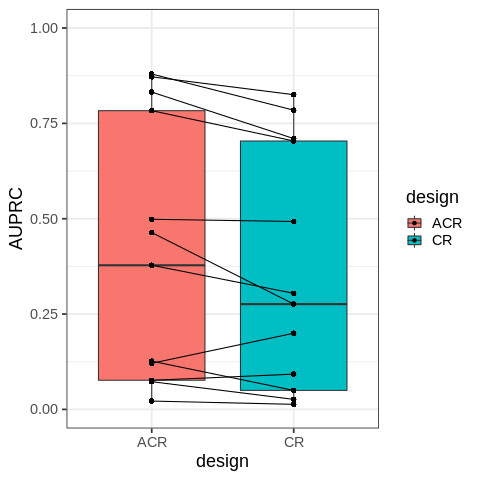

In [39]:
%%R 
cna_auprc_df %>%
# filter(AUPRC > 0.01) %>%
filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_boxplot() +
geom_point() +
geom_line(aes(group=OOR_state_name)) +
theme_bw(base_size=18) +
ylim(0,1) +
theme(strip.text.x=element_text(angle=90))

In [42]:
auprc_res_df_all = pd.DataFrame()
for d in os.listdir(outdir):
    if  not d.endswith('.h5ad') and not d.endswith('.pkl') and d.startswith('qPBMC'):
        print(f'Reading {d}')
        auprc_res_df = pd.read_csv(outdir + d + '/AUPRC_res.csv', index_col = 0)
        auprc_res_df_all = pd.concat([auprc_res_df_all, auprc_res_df])

Reading qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeneutrophil_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_per

In [46]:
auprc_res_df_all = auprc_res_df_all[['AUPRC', 'design', 'OOR_state_name']].drop_duplicates()

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


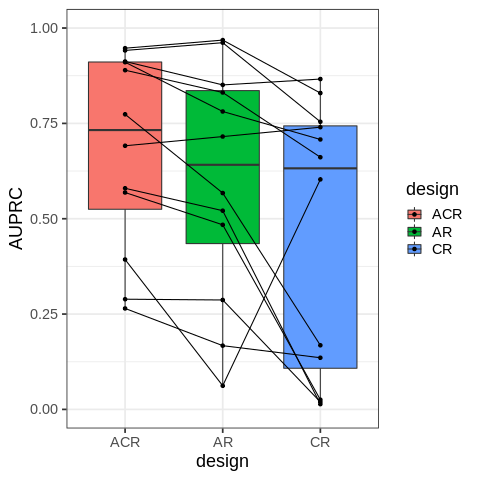

In [49]:
%%R -i auprc_res_df_all 
auprc_res_df_all %>%
filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_boxplot() +
geom_point() +
geom_line(aes(group=OOR_state_name)) +
theme_bw(base_size=18) +
ylim(0,1) +
theme(strip.text.x=element_text(angle=90))

In [ ]:
adata_e

---

In [41]:
import os
import glob
from termcolor import colored

outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
diff_methods = ['meld', 'milo', 'cna']
emb_methods = ['scArches', 'scVI']
n_cells = ['500', '1000']

def _check_output(diff_method, emb_method, n='500'):
    print(f'Subsample {n} cells | {emb_method} embedding | {diff_method}')
    for d in ['ACR', 'AR', 'CR']:
        match_dirs = glob.glob(f'{outdir}/*{n}cells*/')
        match_files = glob.glob(f'{outdir}/*{n}cells*/{d}_design.{emb_method}_{diff_method}.h5ad')
        if len(match_files) == len(match_dirs):
            colored(f'{d} design | {len(match_files)}/{len(match_dirs)} completed', 'green')
        else:
            colored(f'{d} design | {len(match_files)}/{len(match_dirs)} completed', 'red')

for n in n_cells:    
        for emb_method in emb_methods:
            for diff_method in diff_methods:
                _check_output(diff_method, emb_method, n)

Subsample 500 cells | scArches embedding | meld
Subsample 500 cells | scArches embedding | milo
Subsample 500 cells | scArches embedding | cna
Subsample 500 cells | scVI embedding | meld
Subsample 500 cells | scVI embedding | milo
Subsample 500 cells | scVI embedding | cna
Subsample 1000 cells | scArches embedding | meld
Subsample 1000 cells | scArches embedding | milo
Subsample 1000 cells | scArches embedding | cna
Subsample 1000 cells | scVI embedding | meld
Subsample 1000 cells | scVI embedding | milo
Subsample 1000 cells | scVI embedding | cna


 Subsample 500 cells | scArches embedding | cna | 16/16 completed


In [21]:
d

'CR'